# Fantasy Football

In this notebook, I will make an attempt to predict football stats for the NFL player Tom Brady.
These stats could be used in a fantasy football league.

This is a continuation of the previous notebook where we defined and created our `sql` database (using the python module `sqlite3`).
_Now we do not need to interface with `nflgame` to access the data we want._

In this notebook we will load data from the database and make our first predictions.
My predictions will be compared with those from Yahoo! and ESPN, and ultimately graded on the actual outcome in each game.

_This notebook is aimed for running on Google Colab, so first we need to clone this repository to make the data available -- I don't yet know how to clone a git repository into google colab and then use a notebook from that repository, so this is a bit redundant._

In [1]:
import sqlite3
import numpy as np
import pandas as pd

# Load the modules from scikit-learn
from sklearn import svm
from sklearn import neighbors
from sklearn.metrics import explained_variance_score  # quantifying accuracy of regression
from sklearn.model_selection import train_test_split

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

So, we will now prepare the data for training.  We will use `numpy` to easily calculate averages of the columns for different numbers of rows and feed those into the training.

I understand this setup seems a little convoluted:
- convert `nflgame` data into `sql` database
- load `sql` database and re-calculate data, put into `pandas` dataframe
- load into ML tools

At the moment I want some practice with `sql`, and I know how to interface `pandas` dataframes with ML tools.   
I'm using this ~convoluted workflow as a way to practice with `sql`.  
For more developed workflows, I hope to learn more about `sql` and use it directly to interface data with ML tools, or I may just jump straight from `nflgame` into `pandas`.

## Learning

There are only 16 games per season, so the way I have this structured thus far is likely not the most ideal for predicting outcomes.  
Instead, I can imagine a better way would involve using individual plays categorized by many features, e.g., {field position, score, quarter+time remaining, down+distance, OFF/DEF formation, home/away, current stats, and metrics for the game's progression} for both the player of interest and the defense of interest.  
If I have the time, I will investigate such an approach.  For now, I will keep it simple and just use aggregated game information.

In [2]:
ffyear    = 2010
sqlite_db = '../data/nflgame{0}_db.sqlite'.format(ffyear)

In [12]:
conn = sqlite3.connect(sqlite_db)
c = conn.cursor()

tables = c.execute("SELECT * FROM sqlite_master WHERE type='table'")
tables = [t[1] for t in tables]
conn.close()

In [14]:
conn = sqlite3.connect(sqlite_db)
dfs  = {} # contain `sql` database tables as individual dataframes (in a dictionary)
for table in tables:
    dfs[table] = pd.read_sql("SELECT * FROM {0}".format(table), conn)
conn.close()

Now let's update the dataframe so that rows 2-15 represent the averages of all the previous data (week 1 will just be as it is, we won't make predictions for that week).

In [15]:
df_tb12 = dfs['tb12']
print df_tb12

    passing_tds  fumbles_lost  passer_rating  passing_att  passing_cmp  \
0             3             0          120.9           35           25   
1             2             1           72.5           36           20   
2             3             0          142.6           27           21   
3             1             0          107.1           24           19   
4             1             0           69.5           44           27   
5             1             0           82.7           32           19   
6             1             0          100.8           27           16   
7             2             0           90.5           36           19   
8             3             0          125.1           43           30   
9             2             0          123.1           25           19   
10            4             0          158.3           27           21   
11            4             0          148.9           29           21   
12            2             0         

In [22]:
tb12_features = df_tb12.keys()
for feature in df_tb12.keys():
    values = df_tb12[feature].values

    updated_values = [values[0]]
    for v,value in enumerate(values[1:]):
        updated_values.append(np.mean(values[:v+1]))
    df_tb12[feature+'_mean'] = np.asarray(updated_values)

In [23]:
df_tb12

,passing_tds,fumbles_lost,passer_rating,passing_att,passing_cmp,passing_ints,passing_yds,rushing_att,rushing_tds,rushing_yds,passing_tds_mean,fumbles_lost_mean,passer_rating_mean,passing_att_mean,passing_cmp_mean,passing_ints_mean,passing_yds_mean,rushing_att_mean,rushing_tds_mean,rushing_yds_mean
0,3,0,120.9,35,25,0,258,0,0,0,3.000000,0.000000,120.900000,35.000000,25.000000,0.000000,258.000000,0.000000,0.000000,0.000000
1,2,1,72.5,36,20,2,248,0,0,0,3.000000,0.000000,120.900000,35.000000,25.000000,0.000000,258.000000,0.000000,0.000000,0.000000
2,3,0,142.6,27,21,0,252,4,0,6,2.500000,0.500000,96.700000,35.500000,22.500000,1.000000,253.000000,0.000000,0.000000,0.000000
3,1,0,107.1,24,19,0,153,5,0,6,2.666667,0.333333,112.000000,32.666667,22.000000,0.666667,252.666667,1.333333,0.000000,2.000000
4,1,0,69.5,44,27,2,292,2,0,1,2.250000,0.250000,110.775000,30.500000,21.250000,0.500000,227.750000,2.250000,0.000000,3.000000
5,1,0,82.7,32,19,0,159,2,0,1,2.000000,0.200000,102.520000,33.200000,22.400000,0.800000,240.600000,2.200000,0.000000,2.600000
6,1,0,100.8,27,16,0,240,4,0,-3,1.833333,0.166667,99.216667,33.000000,21.833333,0.666667,227.000000,2.166667,0.000000,2.333333
7,2,0,90.5,36,19,0,224,1,0,1,1.714286,0.142857,99.442857,32.142857,21.000000,0.571429,228.857143,2.428571,0.000000,1.571429
8,3,0,125.1,43,30,0,350,1,1,3,1.750000,0.125000,98.325000,32.625000,20.750000,0.500000,228.250000,2.250000,0.000000,1.500000
9,2,0,123.1,25,19,0,186,4,0,-2,1.888889,0.111111,101.300000,33.777778,21.777778,0.444444,241.777778,2.111111,0.111111,1.666667


In [26]:
def avg_stats(df):
    features = df.keys()
    for feature in df.keys():
        values = df[feature].values
    
        updated_values = [values[0]]
        for v,value in enumerate(values[1:]):
            updated_values.append(np.mean(values[:v+1]))
        df[feature+'_mean'] = np.asarray(updated_values)
    return df

In [27]:
# update the remaining dataframes
for table in tables:
    if table=='tb12': continue # did this one first
    dfs[table] = avg_stats(dfs[table])

#### Train/Test Split

Let's split the data into a training and testing set to evaluate performance.
First, we will drop row 0 of the dataframes because those just contain week 1 stats -- our predictions will be for post-week 1.

In [43]:
for table in tables:
    dfs[table] = dfs[table].drop([0])

In [44]:
dfs['tb12']

,passing_tds,fumbles_lost,passer_rating,passing_att,passing_cmp,passing_ints,passing_yds,rushing_att,rushing_tds,rushing_yds,passing_tds_mean,fumbles_lost_mean,passer_rating_mean,passing_att_mean,passing_cmp_mean,passing_ints_mean,passing_yds_mean,rushing_att_mean,rushing_tds_mean,rushing_yds_mean
1,2,1,72.5,36,20,2,248,0,0,0,3.000000,0.000000,120.900000,35.000000,25.000000,0.000000,258.000000,0.000000,0.000000,0.000000
2,3,0,142.6,27,21,0,252,4,0,6,2.500000,0.500000,96.700000,35.500000,22.500000,1.000000,253.000000,0.000000,0.000000,0.000000
3,1,0,107.1,24,19,0,153,5,0,6,2.666667,0.333333,112.000000,32.666667,22.000000,0.666667,252.666667,1.333333,0.000000,2.000000
4,1,0,69.5,44,27,2,292,2,0,1,2.250000,0.250000,110.775000,30.500000,21.250000,0.500000,227.750000,2.250000,0.000000,3.000000
5,1,0,82.7,32,19,0,159,2,0,1,2.000000,0.200000,102.520000,33.200000,22.400000,0.800000,240.600000,2.200000,0.000000,2.600000
6,1,0,100.8,27,16,0,240,4,0,-3,1.833333,0.166667,99.216667,33.000000,21.833333,0.666667,227.000000,2.166667,0.000000,2.333333
7,2,0,90.5,36,19,0,224,1,0,1,1.714286,0.142857,99.442857,32.142857,21.000000,0.571429,228.857143,2.428571,0.000000,1.571429
8,3,0,125.1,43,30,0,350,1,1,3,1.750000,0.125000,98.325000,32.625000,20.750000,0.500000,228.250000,2.250000,0.000000,1.500000
9,2,0,123.1,25,19,0,186,4,0,-2,1.888889,0.111111,101.300000,33.777778,21.777778,0.444444,241.777778,2.111111,0.111111,1.666667
10,4,0,158.3,27,21,0,341,4,0,1,1.900000,0.100000,103.480000,32.900000,21.500000,0.400000,236.200000,2.300000,0.100000,1.300000


To start, we'll just try to predict `passing_yds`.
Now we also need to organize the data a bit more carefully.  

For a given prediction in Week N, we will use the quarterback's average stats from weeks `1:(N-1)` 
with the defense's average stats from weeks `1L(N-1)` that are meeting in the week N game.

I'm now realizing I didn't save the list of opponents in a proper order (will add this back into the `sql` database in a bit) so this will actually require re-accessing the data (who played whom in which week).

In [45]:
import nflgame

In [46]:
opponents = []
games = list(nflgame.games_gen(ffyear, None, "NE","NE"))

for game in games:
    if game.home=="NE":
        opponents.append(game.away)
    else:
        opponents.append(game.home)
print opponents

[u'CIN', u'NYJ', u'BUF', u'MIA', u'BAL', u'SD', u'MIN', u'CLE', u'PIT', u'IND', u'DET', u'NYJ', u'CHI', u'GB', u'BUF', u'MIA']


As expected, there are duplicates for the division teams `BUF`, `MIA`, `NYJ`.

Now this data can be combined into one giant array:

- columns = metrics for TB12 and defenses
- rows    = data from different weeks (average stats from weeks 1:N-1); different rows reflect different DEF each week
    - e.g., for week 2, the data from TB12 is from week 1 and the DEF data is week 1 from NYJ

Our target for week N is the performance of TB12 in week N (we are predicting data in an upcoming game, week N, using historical data, weeks 1:N-1).

In [61]:
features  = {}
for table in tables:
    key = 'qb' if table=='tb12' else 'def'
    features[key] = [i for i in dfs[table].columns.values if i.endswith("_mean")]

Create the new dataframe to contain this re-structured data.  
_This is a very inefficienct approach, I will clean this up once it is all working._

In [65]:
new_columns = [i+"_"+j for i in features.keys() for j in features[i]]

In [68]:
new_data = dict( (k,[]) for k in new_columns)

for i,opp in enumerate(opponents[1:]):
    i += 1

    # get qb features
    qb_feats = features['qb']
    for qb_feat in qb_feats:
        new_data['qb_'+qb_feat].append( dfs['tb12'][qb_feat].loc[i] )

    # get def features
    def_feats = features['def']
    for def_feat in def_feats:
        new_data['def_'+def_feat].append( dfs[opp][def_feat].loc[i] )

# make new dataframe
df_proper = pd.DataFrame.from_dict(new_data)

Just starting with a target of `passing_yds`, so add that to the 'proper' dataframe.

In [95]:
df_proper['passing_yds'] = dfs['tb12'].passing_yds.values
df_proper = df_proper.drop(["def_defense_qbhits_mean"],axis=1)  # seems to be empty...inspect later

In [96]:
df_proper

,def_defense_int_mean,def_defense_pass_def_mean,def_defense_sk_mean,def_defense_sk_yds_mean,def_passer_rating_mean,def_passing_att_mean,def_passing_cmp_mean,def_passing_ints_mean,def_passing_tds_mean,def_passing_yds_mean,...,qb_passer_rating_mean,qb_passing_att_mean,qb_passing_cmp_mean,qb_passing_ints_mean,qb_passing_tds_mean,qb_passing_yds_mean,qb_rushing_att_mean,qb_rushing_tds_mean,qb_rushing_yds_mean,passing_yds
0,1.000000,7.000000,1.500000,-15.000000,62.200000,38.000000,20.000000,1.000000,0.000000,248.000000,...,120.900000,35.000000,25.000000,0.000000,3.000000,258.000000,0.000000,0.000000,0.000000,248
1,0.000000,3.500000,1.500000,-9.000000,101.850000,31.500000,20.000000,0.000000,1.000000,218.500000,...,96.700000,35.500000,22.500000,1.000000,2.500000,253.000000,0.000000,0.000000,0.000000,252
2,1.000000,6.666667,1.833333,-13.333333,79.266667,32.666667,18.333333,1.000000,1.333333,206.666667,...,112.000000,32.666667,22.000000,0.666667,2.666667,252.666667,1.333333,0.000000,2.000000,153
3,0.250000,3.750000,1.625000,-11.750000,69.325000,25.250000,14.000000,0.250000,0.250000,130.750000,...,110.775000,30.500000,21.250000,0.500000,2.250000,227.750000,2.250000,0.000000,3.000000,292
4,1.400000,4.800000,3.700000,-23.000000,68.500000,29.800000,16.800000,1.400000,0.800000,180.000000,...,102.520000,33.200000,22.400000,0.800000,2.000000,240.600000,2.200000,0.000000,2.600000,159
5,1.000000,4.333333,0.916667,-6.500000,86.666667,34.000000,21.833333,1.000000,1.333333,215.666667,...,99.216667,33.000000,21.833333,0.666667,1.833333,227.000000,2.166667,0.000000,2.333333,240
6,1.142857,5.000000,1.785714,-10.857143,93.257143,33.428571,21.285714,1.142857,1.857143,255.857143,...,99.442857,32.142857,21.000000,0.571429,1.714286,228.857143,2.428571,0.000000,1.571429,224
7,1.250000,4.750000,2.812500,-18.125000,83.656250,37.750000,25.375000,1.250000,1.000000,258.125000,...,98.325000,32.625000,20.750000,0.500000,1.750000,228.250000,2.250000,0.000000,1.500000,350
8,1.000000,4.111111,2.055556,-12.555556,85.733333,33.666667,21.222222,1.000000,1.222222,224.444444,...,101.300000,33.777778,21.777778,0.444444,1.888889,241.777778,2.111111,0.111111,1.666667,186
9,0.900000,3.700000,2.450000,-17.200000,92.040000,31.900000,19.500000,0.900000,1.600000,231.300000,...,103.480000,32.900000,21.500000,0.400000,1.900000,236.200000,2.300000,0.100000,1.300000,341


I'll need to do a little more manual inspection to make sure that all of this (ugly) code came together, 
but for now this is a start and we can pass this information into our learning algorithms!

---

In [97]:
features = [i for i in df_proper.columns.values if i.endswith("_mean")]

In [98]:
tmp = df_proper.sample(frac=1) # shuffle the dataframe rows
tts = train_test_split(df_proper[features].values,\
                       df_proper['passing_yds'].values, \
                       test_size=0.25)
X_train,X_test,Y_train,Y_test = tts

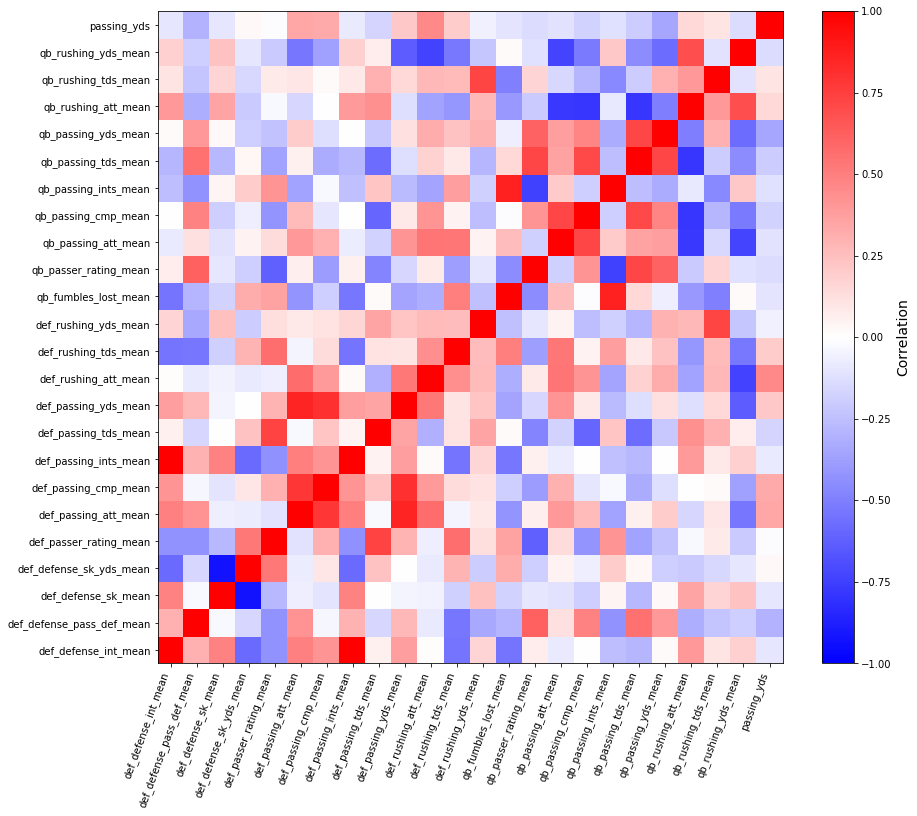

In [105]:
corrmat = df_proper.corr()

fig,ax  = plt.subplots(figsize=(14,12))

opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = plt.pcolor(corrmat, **opts)
cbar    = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Correlation",fontsize=14)

labels = corrmat.columns.values

# shift location of ticks to center of the bins
ax.set_xticks(np.arange(len(labels))+0.5, minor=False);
ax.set_yticks(np.arange(len(labels))+0.5, minor=False);
ax.set_xticklabels(labels, fontsize=10, minor=False, ha='right', rotation=70);
ax.set_yticklabels(labels, fontsize=10, minor=False);

### Pre-process Data

Given we have entries like `passing_yds` and `defense_sk`, there are discrepancies in the orders of magnitude for these values.
Thus, I will go ahead and scale all of the inputs/target and then do our learning.

In [106]:
# Develop the scaling on the training dataset, and then apply the same shift to the test
from sklearn.preprocessing import StandardScaler

# scale features
scaler = StandardScaler()
scaler.fit(X_train)

# scale target values
scaler_target = StandardScaler()
scaler_target.fit(Y_train.reshape(-1,1))

/Users/demarley/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [128]:
# Scale values
X_test_scale  = scaler.transform(X_test)
Y_test_scale  = scaler_target.transform([Y_test])[0]
X_train_scale = scaler.transform(X_train)
Y_train_scale = scaler_target.transform([Y_train])[0]

### K-Nearest Neighbors

In [109]:
from sklearn.metrics import explained_variance_score  # quantifying accuracy of regression

In [131]:
# KNN
n_neighbors = 5
weights = 'uniform'

knn  = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
fknn = knn.fit(X_train_scale, Y_train_scale)
predictions = fknn.predict(X_test_scale)

Distribution = -1.877 $\pm$ 1.1888
EV Score     = 0.315


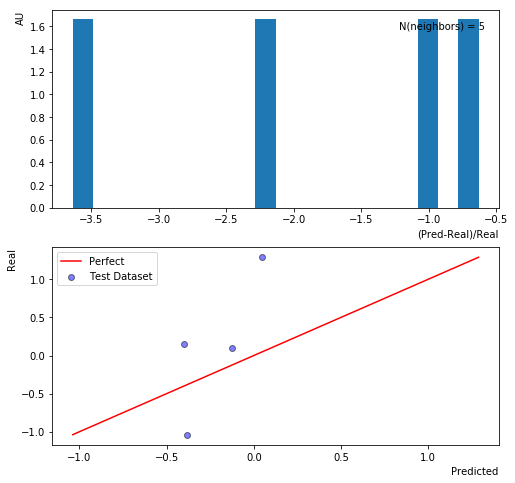

In [132]:
X_val = X_test_scale.copy()
values = np.divide((np.asarray(predictions) - Y_test_scale),Y_test_scale)

fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')
plt.text(0.97,0.90,"N(neighbors) = {0}".format(n_neighbors),ha='right',transform=ax[0].transAxes)

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test_scale,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test_scale,Y_test_scale,color='r',label="Perfect")
plt.xlabel("Predicted",position=(1,0),ha='right')
plt.ylabel("Real",position=(0,1),ha='right')
plt.legend()

evs = explained_variance_score(Y_test_scale,predictions)

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))
print(r"EV Score     = {0:.3f}".format(evs))

In [169]:
# Change the number of neighbors
n_neighbors = 7
weights = 'distance'

knn  = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
fknn = knn.fit(X_train_scale, Y_train_scale)
predictions = fknn.predict(X_test_scale)

Distribution = -1.914 $\pm$ 1.1785
EV Score     = 0.173


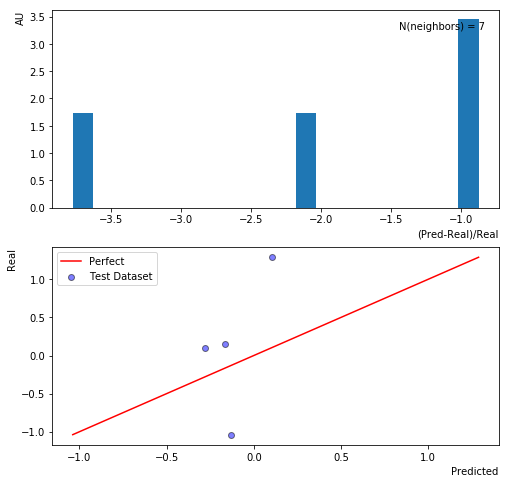

In [170]:
X_val = X_test_scale.copy()
values = np.divide((np.asarray(predictions) - Y_test_scale),Y_test_scale)

fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')
plt.text(0.97,0.90,"N(neighbors) = {0}".format(n_neighbors),ha='right',transform=ax[0].transAxes)

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test_scale,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test_scale,Y_test_scale,color='r',label="Perfect")
plt.xlabel("Predicted",position=(1,0),ha='right')
plt.ylabel("Real",position=(0,1),ha='right')
plt.legend()

evs = explained_variance_score(Y_test_scale,predictions)

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))
print(r"EV Score     = {0:.3f}".format(evs))

### Support Vector Machine

In [140]:
# SVM
# with scikit-learn it is incredibly easy to get started
clf = svm.SVR()  # support vector regression
clf.fit(X_train_scale,Y_train_scale)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Distribution = -1.840 $\pm$ 0.8409
EV Score     = -0.193


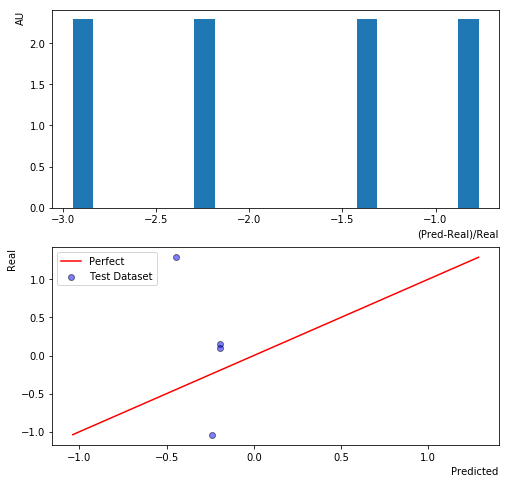

In [142]:
# Performance
predictions = clf.predict(X_test_scale)
values = np.divide((np.asarray(predictions) - Y_test_scale),Y_test_scale)

fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test_scale,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test_scale,Y_test_scale,color='r',label="Perfect")
plt.xlabel("Predicted",position=(1,0),ha='right')
plt.ylabel("Real",position=(0,1),ha='right')
plt.legend()

evs = explained_variance_score(Y_test_scale,predictions)

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))
print(r"EV Score     = {0:.3f}".format(evs))

As expected, this does not actually do that well.

I'm providing these setups with only 11 data points to fit and asking for predictions on 4 values to assess the performance.  
To improve this, I will need to aggregate data across multiple seasons, so that I can start seeing something meaningful.